In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np 
import cv2
import copy
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the data
# traindata = 'CAMUS/training'
# testdata = 'CAMUS/testing'

traindata = '/content/drive/My Drive/CAMUS/training'
testdata = '/content/drive/My Drive/CAMUS/testing'

In [ ]:
'''
Custom Dataset to Load the data
Doc: Take out image one by one and apply transformations upon __getitem__
'''

class CamusIterator(Dataset):
    def __init__(self, data_type, global_transforms, data_file):      
        self.data_type = data_type
        self.data_file = data_file
        self.global_transforms = global_transforms
    
    def __read_image( self, patient_file, suffix ):
        image_file = '{}/{}/{}'.format( self.data_file, patient_file, suffix )
        # # Stolen from a StackOverflow answer
        # # https://stackoverflow.com/questions/37290631/reading-png-raw-format-in-python
        image = cv2.imread(image_file,0)    
        if suffix.find('gt')==-1:
          image = cv2.equalizeHist(image)
        return image

    def __len__( self ):
        return len( os.listdir(self.data_file) )
    
    def __getitem__( self, index ):
        patient_file = 'patient{}'.format( f'{index+1:04}' ) # patient{0001}, patient{0002}, etc
        
        image_2CH_ED = self.__read_image( patient_file, '2CH_ED.png' )
        image_2CH_ES = self.__read_image( patient_file, '2CH_ES.png' )
        image_4CH_ED = self.__read_image( patient_file, '4CH_ED.png' )
        image_4CH_ES = self.__read_image( patient_file, '4CH_ES.png' )

        
        if self.data_type == 'train':
            image_2CH_ED_gt = self.__read_image( patient_file, '2CH_ED_gt.png' )
            image_2CH_ES_gt = self.__read_image( patient_file, '2CH_ES_gt.png' )
            image_4CH_ED_gt = self.__read_image( patient_file, '4CH_ED_gt.png' )
            image_4CH_ES_gt = self.__read_image( patient_file, '4CH_ES_gt.png' )

        
        if self.data_type == 'train':
            data = {
                'patient': patient_file,
                '2CH_ED': image_2CH_ED,
                '2CH_ES': image_2CH_ES,
                '4CH_ED': image_4CH_ED,
                '4CH_ES': image_4CH_ES,
                '2CH_ED_gt': image_2CH_ED_gt,
                '2CH_ES_gt': image_2CH_ES_gt,
                '4CH_ED_gt': image_4CH_ED_gt,
                '4CH_ES_gt': image_4CH_ES_gt,
            }
        elif self.data_type == 'test':
            data = {
                'patient': patient_file,
                '2CH_ED': image_2CH_ED,
                '2CH_ES': image_2CH_ES,
                '4CH_ED': image_4CH_ED,
                '4CH_ES': image_4CH_ES,
            }
        # Transforms
        for transform in self.global_transforms:
            data = transform(data,self.data_type)
            
        return data

    def __iter__( self ):
        for i in range( len(self) ):
            yield self[ i ]

In [ ]:
class TransformTensor(object):
    
    def __init__(self):
        self.data_type = 'test'
        self.fields = [] #['2CH_ED', '2CH_ES', '4CH_ED', '4CH_ES']                
        
    def __call__(self, data, data_type):
      if data_type == 'train':
        self.fields = ['2CH_ED', '2CH_ES', '4CH_ED', '4CH_ES','2CH_ED_gt', '2CH_ES_gt', '4CH_ED_gt', '4CH_ES_gt']
      elif data_type == 'test':
        self.fields = ['2CH_ED', '2CH_ES', '4CH_ED', '4CH_ES']
      for field in self.fields:            
          # transform to tensor
          data[field] = torch.tensor(data[field], dtype = torch.float32)  

      return data

In [ ]:
global_transforms = [TransformTensor()]

In [ ]:
def split_indices(n, val_pct, seed):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Set the random seed (for reproducibility)
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [ ]:
train_iter = CamusIterator(
    data_type='train',
    global_transforms=global_transforms,
    data_file = traindata
)

test_iter = CamusIterator(
    data_type='test',
    global_transforms=global_transforms,
    data_file = testdata
    
)

print('Number of Train Samples in CAMUS: ', len(train_iter))
print('Number of Test Samples in CAMUS: ', len(test_iter))

val_pct = 1/9
rand_seed = 42

train_indices, val_indices = split_indices(len(train_iter), val_pct, rand_seed)

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)


# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)


param_Loader = {'batch_size': 1}

traindata = DataLoader(train_iter, sampler=train_sampler, **param_Loader)
valdata = DataLoader(train_iter, sampler=val_sampler, **param_Loader)
testdata = DataLoader(test_iter, **param_Loader)

print('Train dataloader size:',len(traindata))
print('Val dataloader size:',len(valdata))
print('Test dataloader size:',len(testdata))

Number of Train Samples in CAMUS:  450
Number of Test Samples in CAMUS:  50
Train dataloader size: 400
Val dataloader size: 50
Test dataloader size: 50


In [ ]:
def display_image(patient,fields):
#   fields=['2CH_ED', '2CH_ES', '4CH_ED', '4CH_ES','2CH_ED_gt', '2CH_ES_gt', '4CH_ED_gt', '4CH_ES_gt']
  fig = plt.figure(figsize=(40,60))
  for i,fname in enumerate(fields):
    test = fig.add_subplot(1, len(fields), i + 1)
    image = patient[fname]
    # print(len(np.unique(image)))
    plt.axis('off')
    # print(image.shape)
    plt.imshow(image.squeeze(),cmap = 'gray')
    test.set_title(fname)
  fig.tight_layout()
  plt.show()


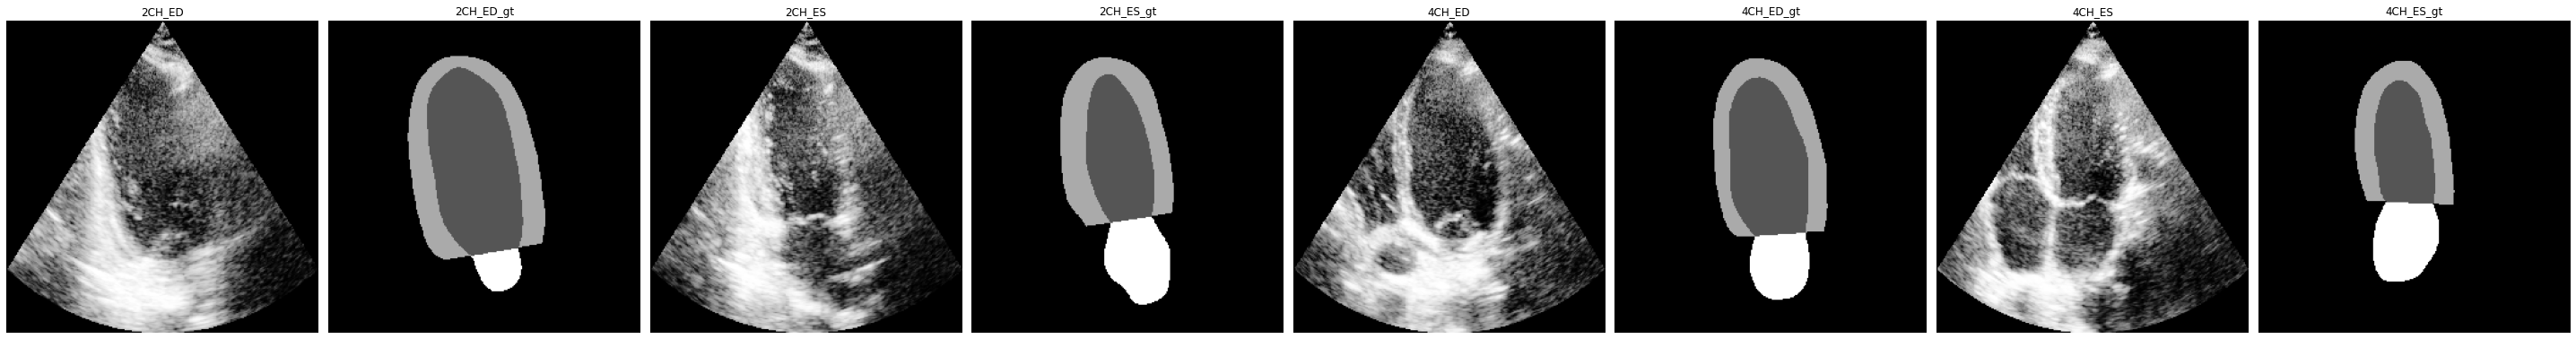

In [ ]:
for i in traindata:
  fields=['2CH_ED','2CH_ED_gt', '2CH_ES', '2CH_ES_gt', '4CH_ED', '4CH_ED_gt', '4CH_ES',  '4CH_ES_gt']
  display_image(i,fields)
  break

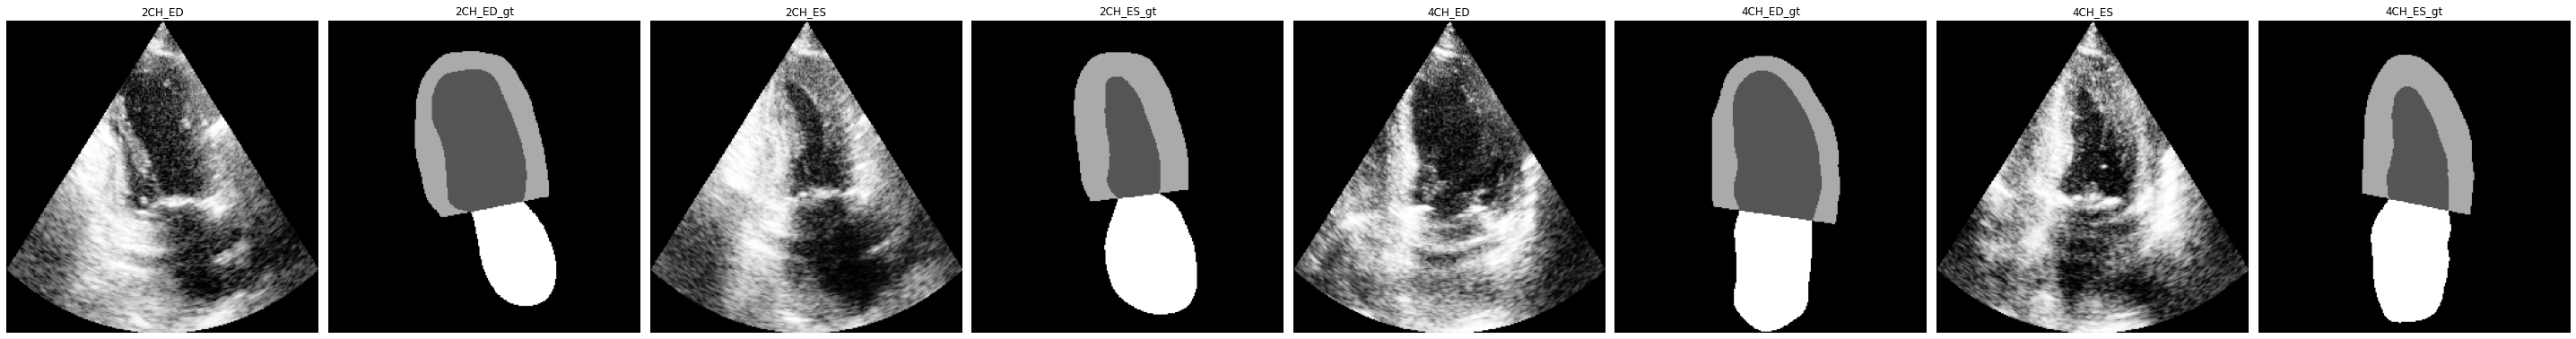

In [ ]:
for i in valdata:
  fields=['2CH_ED','2CH_ED_gt', '2CH_ES', '2CH_ES_gt', '4CH_ED', '4CH_ED_gt', '4CH_ES',  '4CH_ES_gt']
  display_image(i,fields)
  break

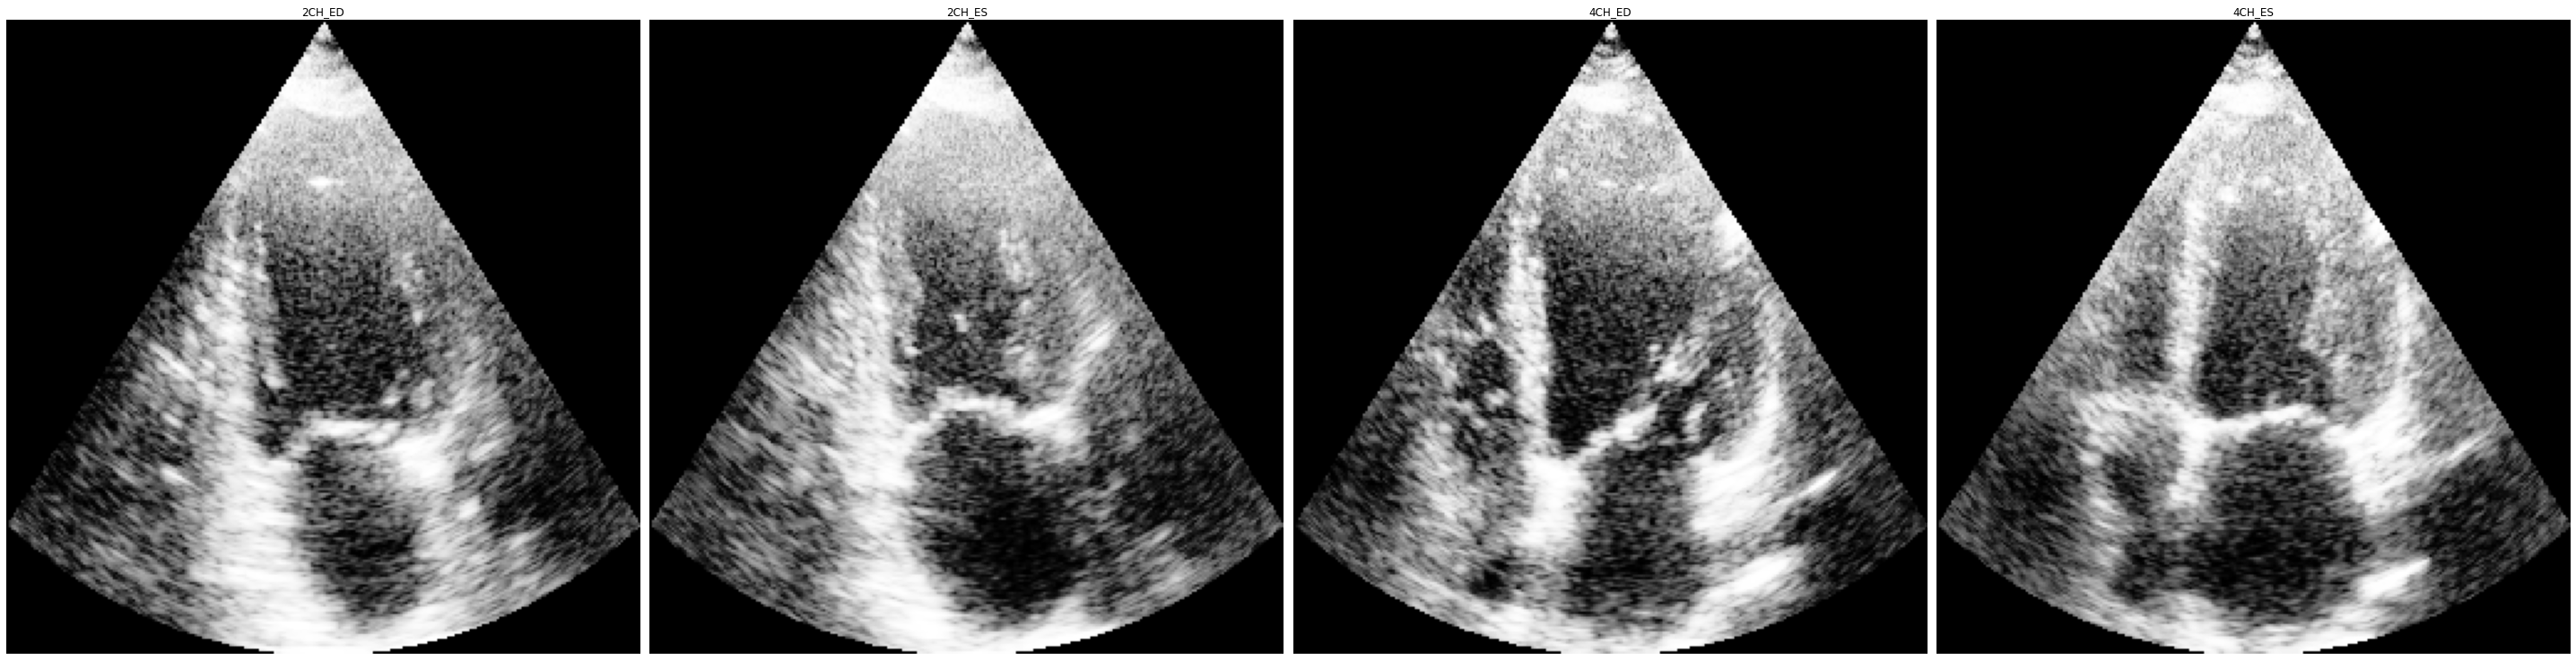

In [ ]:
for i in testdata:
  fields=['2CH_ED', '2CH_ES',  '4CH_ED', '4CH_ES']
  display_image(i,fields)
  break

In [ ]:
def doubleConv2d(in_channel,out_channel):
  convLayer = nn.Sequential(
      nn.Conv2d(in_channel,out_channel,kernel_size = 3,padding=1),
      nn.BatchNorm2d(out_channel),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channel,out_channel,kernel_size = 3,padding=1),
      nn.BatchNorm2d(out_channel),
      nn.ReLU(inplace=True)
  )
  return convLayer

In [ ]:
class UNet1(nn.Module):
  def __init__(self):
    super(UNet1,self).__init__()
    self.max_pool = nn.MaxPool2d(kernel_size = 2 , stride = 2)

    self.downConvLayer_1 = doubleConv2d(1, 32)
    self.downConvLayer_2 = doubleConv2d(32, 32)
    self.downConvLayer_3 = doubleConv2d(32, 64)
    self.downConvLayer_4 = doubleConv2d(64, 128)
    self.downConvLayer_5 = doubleConv2d(128, 128)
    self.downConvLayer_6 = doubleConv2d(128, 128)

    self.upTransConv1 = nn.ConvTranspose2d(
        in_channels = 128,
        out_channels = 128,
        kernel_size = 2,
        stride = 2
    )

    #stacking prev layer..so size increased by 2
    self.upConvLayer_1 = doubleConv2d(256,128)

    self.upTransConv2 = nn.ConvTranspose2d(
        in_channels = 128,
        out_channels = 64,
        kernel_size = 2,
        stride = 2
    )
    self.upConvLayer_2 = doubleConv2d(128,64)

    self.upTransConv3 = nn.ConvTranspose2d(
        in_channels = 64,
        out_channels = 32,
        kernel_size = 2,
        stride = 2
    )
    self.upConvLayer_3 = doubleConv2d(64,32)

    self.upTransConv4 = nn.ConvTranspose2d(
        in_channels = 32,
        out_channels = 32,
        kernel_size = 2,
        stride = 2
    )

    #Layer Up layer: 32 + 32 =64 to Double conv to 16
    self.upConvLayer_4 = doubleConv2d(64,16)

    self.out = nn.Conv2d(
        in_channels = 16,
        out_channels = 4,
        kernel_size = 1
    )
  def forward(self,image):
    #batch_size, channel, height, width
    #Encoder

    #Layer1
    out1 = self.downConvLayer_1(image) #
    # print('Size: ',out1.size())

    #Layer2
    out2 = self.max_pool(out1)
    out3 = self.downConvLayer_2(out2) #
    
    # print('Size: ',out4.size())
    #Layer3
    out4 = self.max_pool(out3)
    out5 = self.downConvLayer_3(out4) #
    
    # print('Size: ',out5.size())
    #Layer4
    out6 = self.max_pool(out5)
    out7 = self.downConvLayer_4(out6) #
    
    # print('Size: ',out7.size())
    #Layer5
    out8 = self.max_pool(out7)
    out9 = self.downConvLayer_5(out8) #
    
    # print('Size: ',out9.size())
    #Layer6
    out10 = self.max_pool(out9)
    out11 = self.downConvLayer_6(out10)
    # print('Size: ',out11.size())
    # return out11


    #decoder
    out = self.upTransConv1(out11)
    upout1 = self.upConvLayer_1(torch.cat([out9,out],axis = 1))
    # print(upout1.size())
    upout2 = self.upTransConv1(upout1)
    upout3 = self.upConvLayer_1(torch.cat([out7,upout2],axis = 1))
    # print(upout3.size())

    upout4 = self.upTransConv2(upout3)
    upout5 = self.upConvLayer_2(torch.cat([out5,upout4],axis = 1))
    # print(upout5.size())

    upout6 = self.upTransConv3(upout5)
    upout7 = self.upConvLayer_3(torch.cat([out3,upout6],axis = 1))
    # print(upout7.size())

    upout8 = self.upTransConv4(upout7)
    upout9 = self.upConvLayer_4(torch.cat([out1,upout8],axis = 1))
    # print(upout8.size())

    finalout = self.out(upout9)
#     print(finalout.size())
    return finalout




In [ ]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
      torch.nn.init.xavier_uniform_(m.weight)
      if m.bias is not None: 
        torch.nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm2d):
      torch.nn.init.normal_(m.weight)
      if m.bias is not None: 
        torch.nn.init.zeros_(m.bias)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
from torchsummary import summary
model = UNet1()
to_device(model,device)
summary(model,input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]           9,248
       BatchNorm2d-9         [-1, 32, 128, 128]              64
             ReLU-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]           9,248
      BatchNorm2d-12         [-1, 32, 128, 128]              64
             ReLU-13         [-1, 32, 128, 128]               0
        MaxPool2d-14           [-1, 32,

In [ ]:
model.apply(weight_init)

UNet1(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (downConvLayer_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (downConvLayer_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (downConvLayer_3): Sequential(
    (0): Conv2d(32, 64, kernel

In [ ]:
def chMask(image):
    arr = np.array(image)
    # print('Hi: ',arr.shape)
    new_arr = np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
    dice_arr = np.zeros((arr.shape[0],4,arr.shape[1],arr.shape[2]))
    # print(arr.shape)
    # print(new_arr.shape)
    # print('elements: ',np.unique(arr))
    ele = np.unique(arr)
    for y in range(arr.shape[2]):
        for x in range(arr.shape[1]):
            if arr[0, x,y] == ele[0]:
                new_arr[0,x,y] = 0
                dice_arr[0, 0,x,y] = 1
            
            elif arr[0, x,y] == ele[1]:
                new_arr[0,x,y] = 1
                dice_arr[0, 1,x,y] = 1
            
            elif arr[0, x,y] == ele[2]:
                new_arr[0,x,y] = 2
                dice_arr[0,2,x,y] = 1
            
            elif arr[0, x,y] == ele[3]:
                new_arr[0,x,y] = 3
                dice_arr[0, 3,x,y] = 1
                
    #new_arr for cross entropy: N,H,W   and  dice_arr for dice loss: N,C,H,W 
    return new_arr,dice_arr

In [ ]:
def dice_loss(output, target, smooth = 1e-5):
    res = F.softmax(output,dim = 1)
    pred = res.cpu().detach().numpy()

    #intersection over HW
    intersection = np.sum(np.sum(pred * target,axis=2),axis=2)
  
    # print('intersection',intersection)
    union = np.sum(np.sum(pred,axis=2),axis=2) + np.sum(np.sum(pred,axis=2),axis=2)

    #MEAN OVER CHANNEL
    dice = ((2. * intersection)/(union+smooth)).mean()
    loss = 1- dice
    return dice

In [ ]:
def calc_loss(pred, target, bce_weight=0.5):
    ce = F.cross_entropy(pred, target.squeeze(1))   # Output: # [N, 4, H, W]  Target : [N, H, W]
    loss = ce  
    return loss 

In [ ]:
def loss_epoch_end(outputs):
  batch_losses = [x['loss'] for x in outputs]
  epoch_loss = torch.stack(batch_losses).mean()
  dice_losses = [x['dice'] for x in outputs]
  dice_epoch_loss = np.mean(dice_losses)
  return {'epoch_loss' : epoch_loss.item(), 'dice_loss' : dice_epoch_loss}
    
def result_epoch_end(epoch,epochs, train_result,valid_result):
  print("Epoch [{}/{}], Train loss: {:.4f}, Valid loss: {:.4f} ".format(epoch+1,epochs, train_result['epoch_loss'],valid_result['epoch_loss']))
  print("Train Dice Score: {:.4f}, Validation Dice Score : {:.4f}".format(train_result['dice_loss'],valid_result['dice_loss']))

In [ ]:
def train_model(model,train_dl,valid_dl,epochs,opt):
  history = [] 
  best_epoch = 0
  best_model_params = copy.deepcopy(model.state_dict())
  best_loss = 99999.9
  img_fields=['2CH_ED' , '2CH_ES', '4CH_ED',  '4CH_ES' ]
  mask_fields = ['2CH_ED_gt', '2CH_ES_gt', '4CH_ED_gt', '4CH_ES_gt']
  for epoch in range(epochs):
    valid_stats = []
    train_stats = []
    # dcloss = 0
    # For training
    for pt in tqdm(train_dl):
      for i, f in enumerate(img_fields):
        # images = images.view(images.size(0), -1)
        images = pt[f]
        images = images.unsqueeze(0)
        images = to_device(images,device)
        output = model(images)      # [N, 4, H, W]
        # print('output shape:',output.shape)
        # print('mask shape:',pt[mask_fields[i]].shape)
        # mask = torch.LongTensor(chMask(pt[mask_fields[i]]))  # [N, 1, H, W] with class indices 0,1,2,3
        gtmask, dcemask = chMask(pt[mask_fields[i]])
        mask = torch.LongTensor(gtmask)
        loss = calc_loss(output,mask.to(device))
        dcloss = dice_loss(output,dcemask)
        opt.zero_grad()
        loss.backward()
        train_stats.append({'loss' : loss, 'dice' : dcloss})
        opt.step()
    train_result = loss_epoch_end(train_stats)


    #For validation
    for pt in tqdm(valid_dl):
      for i, f in enumerate(img_fields):
        images = pt[f]
        images = images.unsqueeze(0)
        images = to_device(images,device)
        gtmask, dcemask = chMask(pt[mask_fields[i]])
        mask = torch.LongTensor(gtmask)
        with torch.no_grad():
            output = model(images)
            loss = calc_loss(output,mask.to(device))
            dcloss = dice_loss(output,dcemask)
            valid_stats.append({'loss' : loss, 'dice' : dcloss}) 
      # break
    valid_result = loss_epoch_end(valid_stats)
    # print(valid_result)

    if best_loss > valid_result['epoch_loss']:
      best_epoch = epoch+1
      best_model_params = copy.deepcopy(model.state_dict())
      best_loss = valid_result['epoch_loss']

    if (epoch+1)%1 == 0:
      result_epoch_end(epoch,epochs,train_result,valid_result)
      
    history.append({'tloss':train_result['epoch_loss'],'vloss':valid_result['epoch_loss'], 'tdloss':train_result['dice_loss'],'vdloss':valid_result['dice_loss']})

  model.load_state_dict(best_model_params)
  print('Best Validation Loss:{:.4f} at Epoch: {}'.format(best_loss,best_epoch))
  return model, history 


In [ ]:
# Setup the loss function
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1

In [ ]:

# model,history =

model,history = train_model(model,traindata,valdata,epochs,opt)


Epoch [1/1], Train loss: 0.5807, Valid loss: 0.3026 
Train Dice Score: 0.4262, Validation Dice Score : 0.5880
Best Validation Loss:0.3026 at Epoch: 1


In [ ]:
##Save Model and history
# torch.save(model.state_dict(), '/content/drive/My Drive/CAMUS Models/wtdicemodel.pth')
# np.save('/content/drive/My Drive/CAMUS Models/dicehistory2.npy',history)

In [ ]:
# # history = np.load('/content/drive/My Drive/CAMUS Models/wtdicehistory.npy',allow_pickle='TRUE').item()
# # print(type(history['tdloss']))
# thist = [i['tloss'] for i in history]
# vhist = [i['vloss'] for i in history]


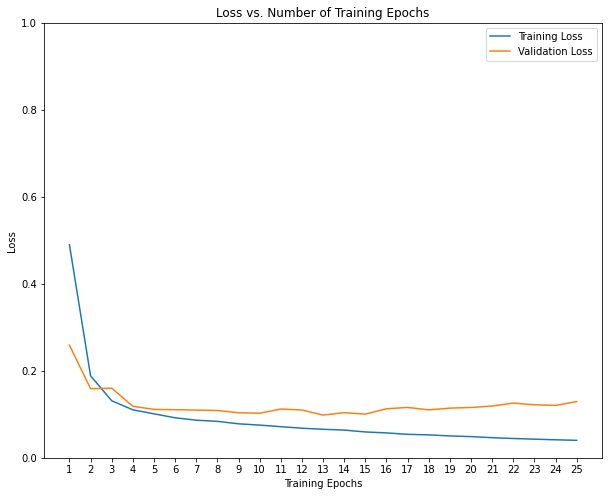

In [ ]:
# plt.figure(figsize=(10,8))
# plt.title('Loss vs. Number of Training Epochs')
# plt.xlabel('Training Epochs')
# plt.ylabel('Loss')
# plt.plot(range(1,len(thist)+1),thist,label="Training Loss")
# plt.plot(range(1,len(thist)+1),vhist,label="Validation Loss")
# plt.ylim((0,1))
# plt.xticks(np.arange(1, epochs+1, 1.0))
# plt.legend()
# plt.show()

In [ ]:
# tdchist = [i['tdloss'] for i in history]
# vdchist = [i['vdloss'] for i in history]

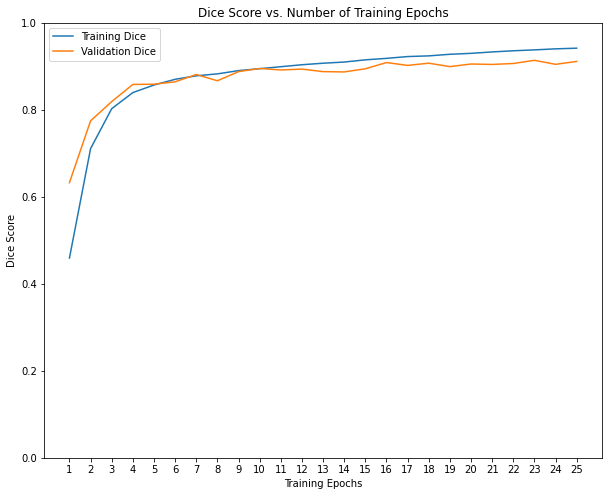

In [ ]:
# plt.figure(figsize=(10,8))
# plt.title('Dice Score vs. Number of Training Epochs')
# plt.xlabel('Training Epochs')
# plt.ylabel('Dice Score')
# plt.plot(range(1,len(tdchist)+1),tdchist,label="Training Dice")
# plt.plot(range(1,len(vdchist)+1),vdchist,label="Validation Dice")
# plt.ylim((0,1))
# plt.xticks(np.arange(1, epochs+1, 1.0))
# plt.legend()
# plt.show()

In [ ]:
# model = UNet1()
# model.load_state_dict(torch.load('/content/drive/My Drive/CAMUS Models/wtdicemodel.pth',map_location=torch.device(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))))
# to_device(model,device)
# summary(model,input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]           9,248
       BatchNorm2d-9         [-1, 32, 128, 128]              64
             ReLU-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]           9,248
      BatchNorm2d-12         [-1, 32, 128, 128]              64
             ReLU-13         [-1, 32, 128, 128]               0
        MaxPool2d-14           [-1, 32,

In [ ]:
def segImg(image):
    arr = np.array(image)
    new_arr = np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
    for y in range(arr.shape[2]):
        for x in range(arr.shape[1]):
            if arr[0,x,y] == 0:
                new_arr[0,x,y] = 0.0
            elif arr[0, x,y] == 1:
                new_arr[0,x,y] = 85.0
            elif arr[0,x,y] == 2:
                new_arr[0,x,y] = 170.0
            elif arr[0, x,y] == 3:
                new_arr[0, x,y] = 255.0
    return new_arr.squeeze()

In [ ]:
def evaluate(model,test_dl):
  img_fields=['2CH_ED', '2CH_ES', '4CH_ED',  '4CH_ES' ]
  count = 0
  for pt in tqdm(test_dl):

    if(count != 3):
      count+=1
    else:
      break

    for i, f in enumerate(img_fields):
      images = pt[f]
      images = images.unsqueeze(0)
      images = to_device(images,device)
      with torch.no_grad():
          output = model(images)
      res = F.softmax(output,dim = 1)
      x = torch.argmax(res,dim=1)
      sImg = segImg(x.cpu())
      plt.imshow(images.squeeze().cpu(),cmap='gray')
      plt.show()
      plt.imshow(sImg,cmap='gray')
      plt.show()

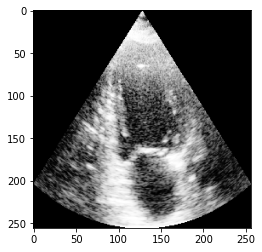

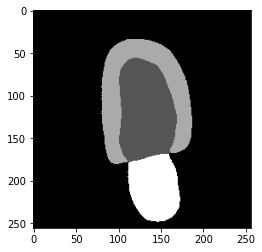

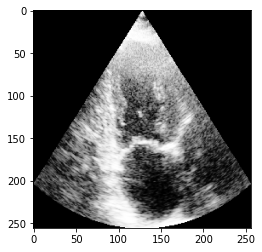

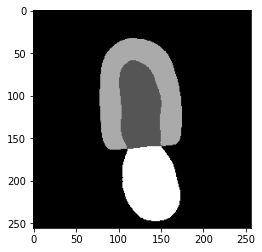

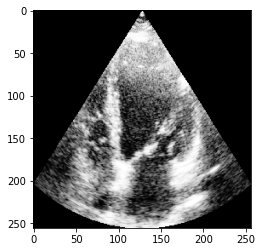

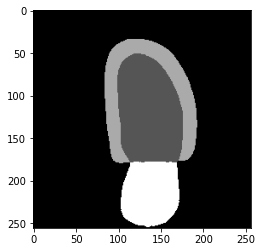

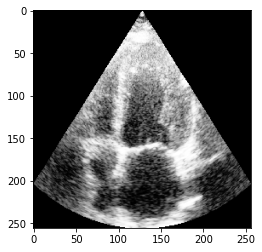

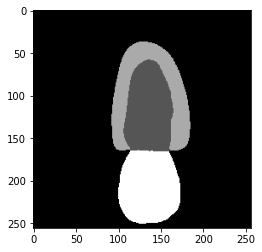

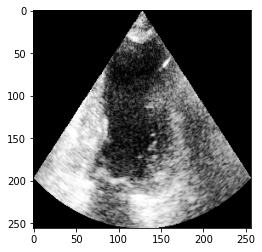

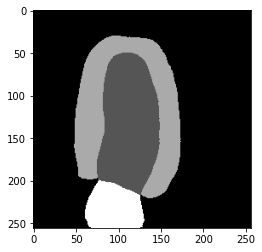

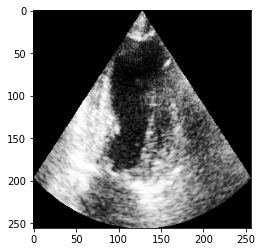

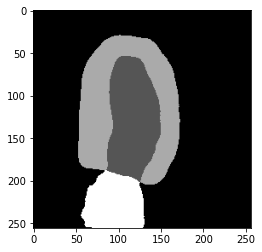

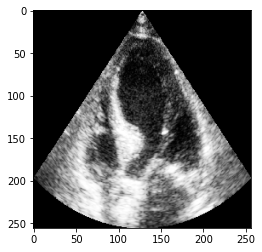

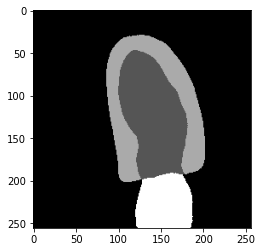

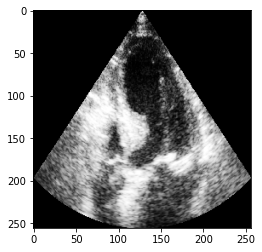

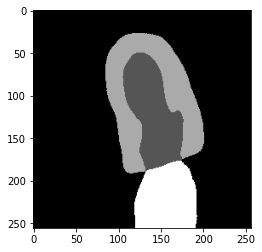

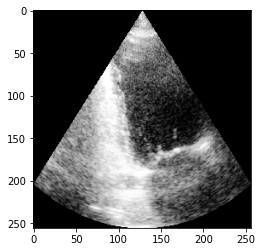

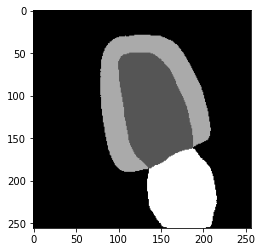

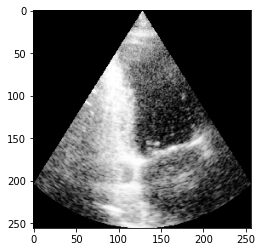

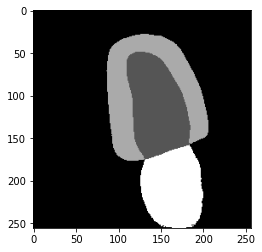

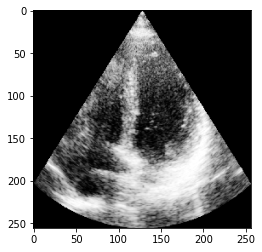

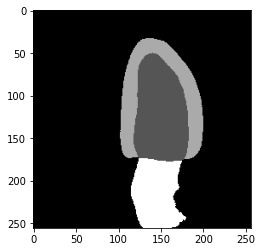

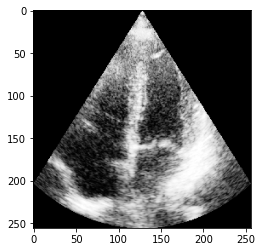

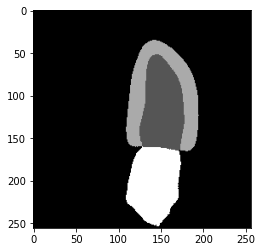

In [ ]:
evaluate(model,testdata)